In [8]:
#Importing the necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model
import warnings
warnings.filterwarnings('ignore')

### Importing the data

In [9]:
train = pd.read_csv('labelled_training_data.csv')
validation = pd.read_csv('labelled_validation_data.csv')
test = pd.read_csv('labelled_testing_data.csv')

### Exploratory Data Analysis (EDA)

In [10]:
data=train[["eventId","parentProcessId" ,"mountNamespace", "returnValue","argsNum"]]

Summary Statistics:
             eventId  parentProcessId  mountNamespace    returnValue  \
count  763144.000000    763144.000000    7.631440e+05  763144.000000   
mean      288.158953      1882.216609    4.026532e+09      17.520924   
std       385.117778      2215.563094    1.649030e+02     318.596662   
min         3.000000         0.000000    4.026532e+09    -115.000000   
25%         3.000000       187.000000    4.026532e+09       0.000000   
50%        62.000000      1385.000000    4.026532e+09       0.000000   
75%       257.000000      1648.000000    4.026532e+09       4.000000   
max      1010.000000      7672.000000    4.026532e+09    8289.000000   

             argsNum  
count  763144.000000  
mean        2.672082  
std         1.340906  
min         0.000000  
25%         1.000000  
50%         3.000000  
75%         4.000000  
max         5.000000  


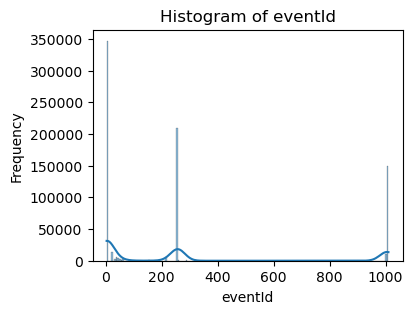

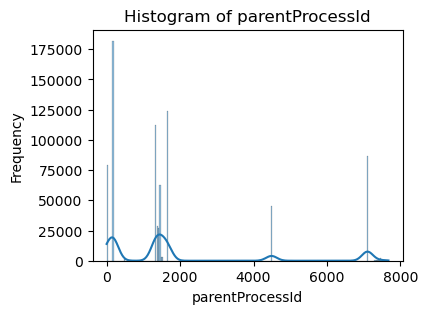

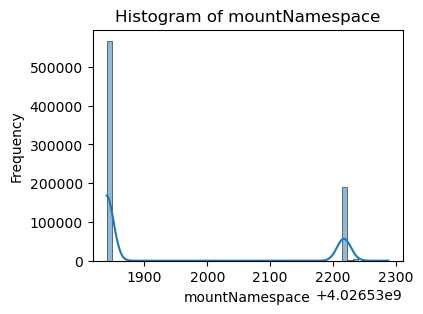

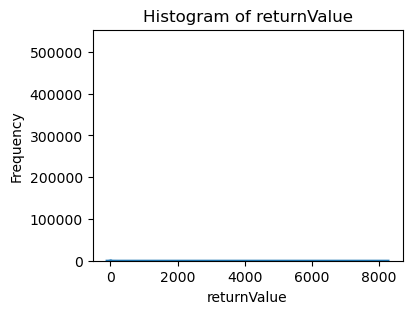

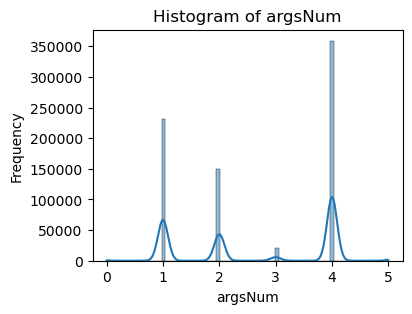

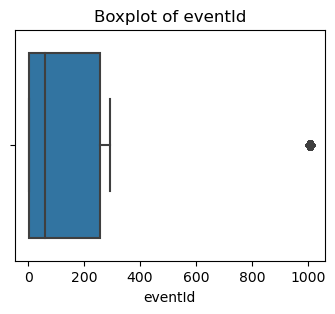

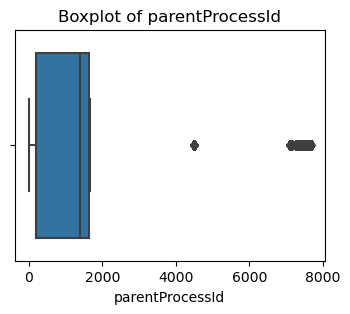

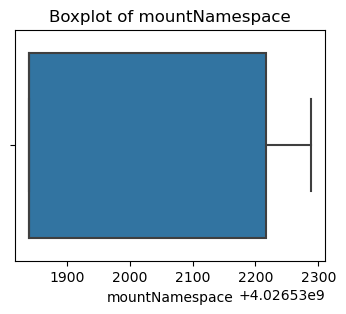

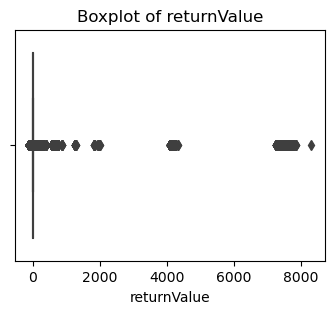

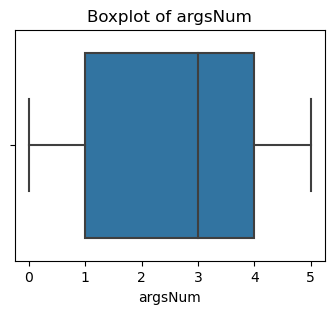

In [4]:
# Univariate Analysis
def univariate_analysis(data):
    # Summary statistics
    print("Summary Statistics:")
    print(data.describe())

    # Histograms for numeric features
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(4, 3))
        sns.histplot(data[col], kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        #plt.savefig('')
        plt.show()

    # Boxplots for numeric features
    for col in numeric_cols:
        plt.figure(figsize=(4, 3))
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()

    # Count plots for categorical features
    categorical_cols = data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        plt.figure(figsize=(4, 3))
        sns.countplot(data[col])
        plt.title(f'Countplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
#perform the bivariate analysis
univariate_analysis(data)

### Data Preprocessing

In [11]:
train['win']=1
test['win']=0
#merge the train set and the test set
df=pd.concat([train,test]).reset_index(drop=True)

In [12]:
df=df.drop(['timestamp'],axis=1)
df['processId'] = df['processId'].apply(lambda x: 0 if x>=3 else 1)
df['parentProcessId'] = df['parentProcessId'].apply(lambda x: 0 if x>=3 else 1)
df['mountNamespace'] = df['mountNamespace'].apply(lambda x: 1 if x==402653184 else 0)
df=df.drop(['eventName','stackAddresses','processName','hostName','args'],axis=1)
def condition(x):
    if x>0:
        return 1
    elif x<0:
        return -1
    else:
        return 0
df['returnValue'] = df['returnValue'].apply(condition)

In [13]:
#Regaining the train and test feature
train=df[df['win']==1]
test=df[df['win']==0]

In [16]:
train=train
train.head(1)

,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil,win
0,0,7337,1,100,0,157,5,0,1,0,1


In [8]:
test=test
test.head(1)

,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil,win
763144,0,382,1,101,0,41,3,1,0,0,0


### Building the model

In [17]:
model=IsolationForest(contamination=0.1)

In [18]:
train =train.drop(['evil'],axis=1)
test =test.drop(['evil'],axis=1)
train.head(1)

,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,win
0,0,7337,1,100,0,157,5,0,1,1


In [22]:
#training the model
model.fit(train)

IsolationForest(contamination=0.1)

In [23]:
#predicting on the test dataset
predictions=model.predict(test)

In [26]:
test['anomaly'] = predictions

In [27]:
test['anomaly'].value_counts()

anomaly
-1    159740
 1     29227
Name: count, dtype: int64

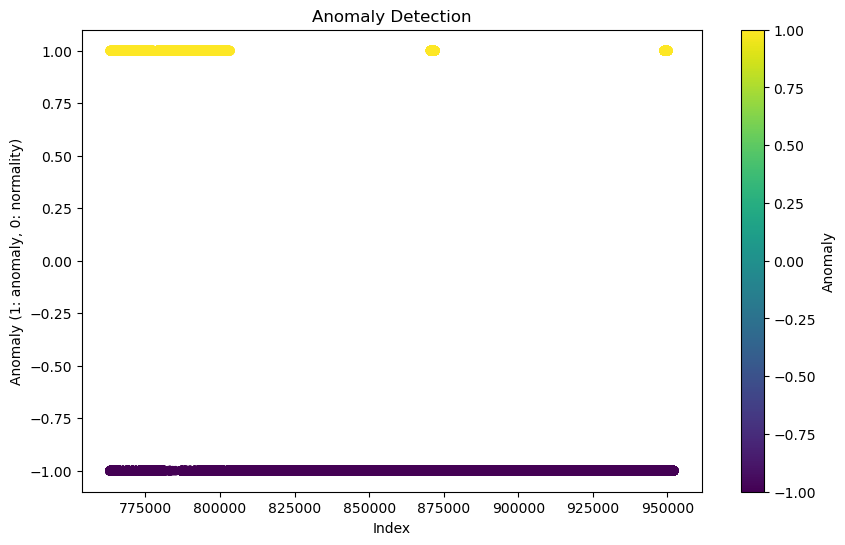

In [30]:
# Plotting the outliers
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['anomaly'], c=test['anomaly'], cmap='viridis')
plt.xlabel('Index')
plt.ylabel('Anomaly (1: anomaly, 0: normality)')
plt.title('Anomaly Detection')
plt.colorbar(label='Anomaly')
plt.show()